# Liquidity Risk and Expected Stock Returns (Pastor Stambaugh 2003)
*Replication study by Eric Vorkink and Andrew Williams*

*We will proceed in the following manner*

1. Replicate the data/measures in the sample that they use
2. Replicate main results/tables (not all tables will be replicated)
3. Test their measures and results moving forward

**Replicating Data/Measures in sample** 

In [84]:
pip install linearmodels

  Using cached mypy_extensions-1.0.0-py3-none-any.whl (4.7 kB)
  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)
  Using cached formulaic-0.5.2-py3-none-any.whl (77 kB)
  Using cached pyhdfe-0.1.2-py3-none-any.whl (18 kB)
  Using cached setuptools_scm-7.1.0-py3-none-any.whl (43 kB)
  Using cached interface_meta-1.3.0-py3-none-any.whl (14 kB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Using cached tomli-2.0.1-py3-none-any.whl (12 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.2
    Uninstalling typing-extensions-3.7.4.2:
      Successfully uninstalled typing-extensions-3.7.4.2
Note: you may need to restart the kernel to use updated packages.


In [61]:
## Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from linearmodels import PooledOLS
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
## Reading in our liquidity measure that we created
## WE NEED TO ADD IN THE CODE THAT WE USED TO CREATE THIS
liq=pd.read_feather('C:\\Users\ericv\Box\School\Winter 2023\Fin 585R\Project\liq_data_updated.feather')
liq['vals']=liq['vals']*1000000
liq

,index,vals
0,10192610006,1.191493e-03
1,10192610022,1.342261e-02
2,10192610030,4.944852e-02
3,10192610049,-3.803185e-02
4,10192610057,NaN
...,...,...
3549131,9202293425,-2.938097e-04
3549132,9202293426,-5.287389e-03
3549133,9202293427,4.332515e-05
3549134,9202293429,-1.978194e-05


In [3]:
# Reading in monthly stock data from CRSP
#path = r"C:\\Users\ericv\Downloads\06-mstk_62-22 (1).csv"
path=r"C:\\Users\ericv\Downloads\crsp_monthly.csv"
df=pd.read_csv(path,parse_dates=['caldt'])
df

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr
0,10000,1986-01-31,68391610,OMFGA,10,3,3990,-4.37500,NaN,1771.0,3680.0,1.0
1,10000,1986-02-28,68391610,OMFGA,10,3,3990,-3.25000,-0.257143,828.0,3680.0,1.0
2,10000,1986-03-31,68391610,OMFGA,10,3,3990,-4.43750,0.365385,1078.0,3680.0,1.0
3,10000,1986-04-30,68391610,OMFGA,10,3,3990,-4.00000,-0.098592,957.0,3793.0,1.0
4,10000,1986-05-30,68391610,OMFGA,10,3,3990,-3.10938,-0.222656,1074.0,3793.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4776837,93436,2022-08-31,88160R10,TSLA,11,3,9999,275.61000,-0.072489,7322220.0,3133470.0,1.0
4776838,93436,2022-09-30,88160R10,TSLA,11,3,9999,265.25000,-0.037589,12965500.0,3158000.0,1.0
4776839,93436,2022-10-31,88160R10,TSLA,11,3,9999,227.54000,-0.142168,17325800.0,3157750.0,1.0
4776840,93436,2022-11-30,88160R10,TSLA,11,3,9999,194.70000,-0.144326,18824200.0,3157750.0,1.0


In [4]:
# We want all dates to be the last day of the month
df['caldt']=df['caldt'] + pd.offsets.MonthEnd(0) 

In [5]:
## Some date cleaning of our liquidity measure table - this will allow us a proper merge with CRSP data
liq['datepermno']=pd.to_numeric(liq['index'])
liq['permno']=pd.to_numeric(liq['datepermno'].astype(str).str[-5:])
liq['caldt']=pd.to_numeric(liq['datepermno'].astype(str).str[:-5])
liq['newdate']=liq['caldt'].astype(str).str[:-4] + '-' + liq['caldt'].astype(str).str[-4:]
liq['caldt']=pd.to_datetime(liq['caldt'])

In [6]:
liq['caldt']=pd.to_datetime(liq['newdate'])
liq['caldt']=liq['caldt'] + pd.offsets.MonthEnd(0) 

<ipython-input-6-697db353df9a>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  liq['caldt']=pd.to_datetime(liq['newdate'])


In [7]:
liq=liq.drop(['index','datepermno','newdate'],axis=1)

In [8]:
liq=liq.sort_values(['permno','caldt']).reset_index(drop=True)

In [9]:
## Merge month-stock liquidity measure with CRSP monthly data
df=df.merge(liq,on=['permno','caldt'])
df

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,5.330482e-01
1,10001,1986-10-31,39040610,GFGC,11,3,4920,6.625,0.039216,362.0,991.0,3.0,4.991615e-02
2,10001,1986-11-30,39040610,GFGC,11,3,4920,7.000,0.056604,312.0,991.0,3.0,-1.580374e-01
3,10001,1986-12-31,39040610,GFGC,11,3,4920,7.000,0.015000,312.0,991.0,3.0,-1.390274e+00
4,10001,1987-01-31,39040610,GFGC,11,3,4920,6.750,-0.035714,399.0,991.0,3.0,-7.518338e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534897,93436,2022-05-31,88160R10,TSLA,11,3,9999,758.260,-0.129197,6470840.0,1036010.0,3.0,-5.279940e-07
3534898,93436,2022-06-30,88160R10,TSLA,11,3,9999,673.420,-0.111888,6684630.0,1041000.0,3.0,2.189319e-07
3534899,93436,2022-07-31,88160R10,TSLA,11,3,9999,891.450,0.323765,5800690.0,1044490.0,3.0,3.855547e-08
3534900,93436,2022-08-31,88160R10,TSLA,11,3,9999,275.610,-0.072489,7322220.0,3133470.0,1.0,-2.491951e-07


In [10]:
## Create company value column
df['stock_val']=df['prc']*df['shr']

In [11]:
## Restrict sample to Aug 1962 and beyond using dfrep
dfrep=df.query("caldt>='1962-07-01'").reset_index(drop=True)

In [12]:
## Lag company value
dfrep.dropna()
dfrep['stock_val_lag']=dfrep.groupby('permno')['stock_val'].shift(1)

In [13]:
## Create the avg monthly liquidity across the sample. This is the gamma-hat sub t measure in the paper
monthdf=dfrep.groupby('caldt')['vals'].mean().to_frame()
monthdf

,vals
caldt,
1962-07-31,-0.046902
1962-08-31,0.011638
1962-09-30,-0.053053
1962-10-31,-0.244977
1962-11-30,-0.065033
...,...
2022-05-31,0.000915
2022-06-30,0.000635
2022-07-31,-0.000872


In [14]:
## Add in the scaling factor mt from the paper, it is the sum of lagged company value for stocks used in vals at time t
monthdf['mt']=dfrep.groupby('caldt')['stock_val_lag'].sum()
monthdf=monthdf.query("caldt>='1962-08-01'")
monthdf

,vals,mt
caldt,,
1962-08-31,0.011638,3.255810e+08
1962-09-30,-0.053053,3.235160e+08
1962-10-31,-0.244977,3.099985e+08
1962-11-30,-0.065033,3.141059e+08
1962-12-31,-0.051226,3.479098e+08
...,...,...
2022-05-31,0.000915,5.218094e+10
2022-06-30,0.000635,5.256506e+10
2022-07-31,-0.000872,4.938732e+10


In [15]:
## Scale m by m1 (keeps everything in 1962 dollars scale)
dfm1=dfrep.query("caldt >= '1962-08-27' and caldt<='1962-08-31'")
m1=dfm1['stock_val'].sum()
m1

323648015.4375

In [16]:
## m is now our scaling factor that will be used in a few places throughout the paper. It is at the month level.
monthdf['m']=monthdf['mt']/m1
monthdf

,vals,mt,m
caldt,,,
1962-08-31,0.011638,3.255810e+08,1.005972
1962-09-30,-0.053053,3.235160e+08,0.999592
1962-10-31,-0.244977,3.099985e+08,0.957826
1962-11-30,-0.065033,3.141059e+08,0.970517
1962-12-31,-0.051226,3.479098e+08,1.074963
...,...,...,...
2022-05-31,0.000915,5.218094e+10,161.227443
2022-06-30,0.000635,5.256506e+10,162.414269
2022-07-31,-0.000872,4.938732e+10,152.595769


In [17]:
monthdf['vals'].describe()

count    722.000000
mean      -0.008216
std        0.021715
min       -0.244977
25%       -0.009322
50%       -0.001045
75%        0.000972
max        0.037045
Name: vals, dtype: float64

**Now that the data is ready, we will recreate some of the results from the paper:**
1. Figure 1
2. Table 2
3. Table 3
4. Table 4
5. Table 5
6. Table 7
7. Table 8

In [18]:
## Figure 1! Plotting val is the scaled liquidity measure that we will plot. We recreate their plot extremely well.
monthdf['plottingval']=monthdf['vals']*monthdf['m']
monthdf

,vals,mt,m,plottingval
caldt,,,,
1962-08-31,0.011638,3.255810e+08,1.005972,0.011707
1962-09-30,-0.053053,3.235160e+08,0.999592,-0.053031
1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645
1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116
1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066
...,...,...,...,...
2022-05-31,0.000915,5.218094e+10,161.227443,0.147467
2022-06-30,0.000635,5.256506e+10,162.414269,0.103177
2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136


*Figure 1*

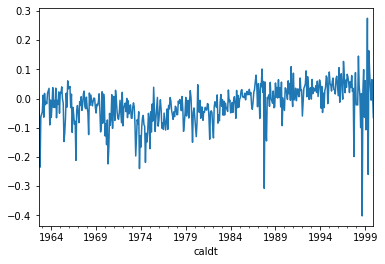

In [19]:
monthdf.loc['1962-01-01':'1999-12-31']['plottingval'].plot()
plt.show()

In [20]:
## We are now recreating the measure Lt - "The innovation in liquidity"
liq['lagvals']=liq.groupby('permno')['vals'].shift(1)

In [21]:
liq['diff']=liq['vals']-liq['lagvals']
liq

,vals,permno,caldt,lagvals,diff
0,5.330482e-01,10001,1986-09-30,NaN,NaN
1,4.991615e-02,10001,1986-10-31,5.330482e-01,-4.831320e-01
2,-1.580374e-01,10001,1986-11-30,4.991615e-02,-2.079535e-01
3,-1.390274e+00,10001,1986-12-31,-1.580374e-01,-1.232237e+00
4,-7.518338e-02,10001,1987-01-31,-1.390274e+00,1.315091e+00
...,...,...,...,...,...
3549131,-5.279940e-07,93436,2022-05-31,NaN,NaN
3549132,2.189319e-07,93436,2022-06-30,-5.279940e-07,7.469259e-07
3549133,3.855547e-08,93436,2022-07-31,2.189319e-07,-1.803764e-07
3549134,-2.491951e-07,93436,2022-08-31,3.855547e-08,-2.877506e-07


In [22]:
monthdf['plottingval_lag']=monthdf['plottingval'].shift(1)
monthdf['delta_gamma']=monthdf['plottingval']-monthdf['plottingval_lag']
monthdf

,vals,mt,m,plottingval,plottingval_lag,delta_gamma
caldt,,,,,,
1962-08-31,0.011638,3.255810e+08,1.005972,0.011707,NaN,NaN
1962-09-30,-0.053053,3.235160e+08,0.999592,-0.053031,0.011707,-0.064739
1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645,-0.053031,-0.181614
1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,-0.234645,0.171529
1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.063116,0.008050
...,...,...,...,...,...,...
2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,-0.602138,0.749604
2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.147467,-0.044290
2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,0.103177,-0.236313


In [23]:
monthdf['delta_gamma_lag']=monthdf['delta_gamma'].shift(1)
monthdf

,vals,mt,m,plottingval,plottingval_lag,delta_gamma,delta_gamma_lag
caldt,,,,,,,
1962-08-31,0.011638,3.255810e+08,1.005972,0.011707,NaN,NaN,NaN
1962-09-30,-0.053053,3.235160e+08,0.999592,-0.053031,0.011707,-0.064739,NaN
1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645,-0.053031,-0.181614,-0.064739
1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,-0.234645,0.171529,-0.181614
1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.063116,0.008050,0.171529
...,...,...,...,...,...,...,...
2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,-0.602138,0.749604,-0.885585
2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.147467,-0.044290,0.749604
2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,0.103177,-0.236313,-0.044290


In [24]:
monthdf['gamma_lag']=monthdf['vals'].shift(1)
monthdf['gamma_lag_scaled']=monthdf['gamma_lag']*monthdf['m']
monthdf=monthdf.reset_index()
monthdf=monthdf.dropna()
monthdf

,caldt,vals,mt,m,plottingval,plottingval_lag,delta_gamma,delta_gamma_lag,gamma_lag,gamma_lag_scaled
2,1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645,-0.053031,-0.181614,-0.064739,-0.053053,-0.050816
3,1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,-0.234645,0.171529,-0.181614,-0.244977,-0.237754
4,1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.063116,0.008050,0.171529,-0.065033,-0.069908
5,1963-01-31,-0.041654,3.525328e+08,1.089248,-0.045371,-0.055066,0.009695,0.008050,-0.051226,-0.055798
6,1963-02-28,0.010197,3.696912e+08,1.142263,0.011647,-0.045371,0.057018,0.009695,-0.041654,-0.047579
...,...,...,...,...,...,...,...,...,...,...
717,2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,-0.602138,0.749604,-0.885585,-0.003419,-0.551310
718,2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.147467,-0.044290,0.749604,0.000915,0.148552
719,2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,0.103177,-0.236313,-0.044290,0.000635,0.096940
720,2022-08-31,0.005111,5.439598e+10,168.071408,0.859055,-0.133136,0.992190,-0.236313,-0.000872,-0.146638


In [25]:
## Our function to get innovation in liquidity
def get_resid(x):
    reg=smf.ols('delta_gamma ~ 1 + delta_gamma_lag + gamma_lag_scaled',data=x).fit()
    return reg.resid*.01

In [26]:
monthdf

,caldt,vals,mt,m,plottingval,plottingval_lag,delta_gamma,delta_gamma_lag,gamma_lag,gamma_lag_scaled
2,1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645,-0.053031,-0.181614,-0.064739,-0.053053,-0.050816
3,1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,-0.234645,0.171529,-0.181614,-0.244977,-0.237754
4,1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.063116,0.008050,0.171529,-0.065033,-0.069908
5,1963-01-31,-0.041654,3.525328e+08,1.089248,-0.045371,-0.055066,0.009695,0.008050,-0.051226,-0.055798
6,1963-02-28,0.010197,3.696912e+08,1.142263,0.011647,-0.045371,0.057018,0.009695,-0.041654,-0.047579
...,...,...,...,...,...,...,...,...,...,...
717,2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,-0.602138,0.749604,-0.885585,-0.003419,-0.551310
718,2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.147467,-0.044290,0.749604,0.000915,0.148552
719,2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,0.103177,-0.236313,-0.044290,0.000635,0.096940
720,2022-08-31,0.005111,5.439598e+10,168.071408,0.859055,-0.133136,0.992190,-0.236313,-0.000872,-0.146638


In [27]:
monthdf['Lt']=get_resid(monthdf)
monthdf

,caldt,vals,mt,m,plottingval,plottingval_lag,delta_gamma,delta_gamma_lag,gamma_lag,gamma_lag_scaled,Lt
2,1962-10-31,-0.244977,3.099985e+08,0.957826,-0.234645,-0.053031,-0.181614,-0.064739,-0.053053,-0.050816,-0.002038
3,1962-11-30,-0.065033,3.141059e+08,0.970517,-0.063116,-0.234645,0.171529,-0.181614,-0.244977,-0.237754,0.000010
4,1962-12-31,-0.051226,3.479098e+08,1.074963,-0.055066,-0.063116,0.008050,0.171529,-0.065033,-0.069908,0.000368
5,1963-01-31,-0.041654,3.525328e+08,1.089248,-0.045371,-0.055066,0.009695,0.008050,-0.051226,-0.055798,0.000038
6,1963-02-28,0.010197,3.696912e+08,1.142263,0.011647,-0.045371,0.057018,0.009695,-0.041654,-0.047579,0.000567
...,...,...,...,...,...,...,...,...,...,...,...
717,2022-05-31,0.000915,5.218094e+10,161.227443,0.147467,-0.602138,0.749604,-0.885585,-0.003419,-0.551310,0.001951
718,2022-06-30,0.000635,5.256506e+10,162.414269,0.103177,0.147467,-0.044290,0.749604,0.000915,0.148552,0.002754
719,2022-07-31,-0.000872,4.938732e+10,152.595769,-0.133136,0.103177,-0.236313,-0.044290,0.000635,0.096940,-0.001604
720,2022-08-31,0.005111,5.439598e+10,168.071408,0.859055,-0.133136,0.992190,-0.236313,-0.000872,-0.146638,0.008643


In [28]:
## Let's get started on replicating table 2:
## We need to get our predicted liquidity betas. we need to get back to df, lets make a copy so we don't worry about dropna
dfrep=df
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals,stock_val
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,5.330482e-01,6.317625e+03
1,10001,1986-10-31,39040610,GFGC,11,3,4920,6.625,0.039216,362.0,991.0,3.0,4.991615e-02,6.565375e+03
2,10001,1986-11-30,39040610,GFGC,11,3,4920,7.000,0.056604,312.0,991.0,3.0,-1.580374e-01,6.937000e+03
3,10001,1986-12-31,39040610,GFGC,11,3,4920,7.000,0.015000,312.0,991.0,3.0,-1.390274e+00,6.937000e+03
4,10001,1987-01-31,39040610,GFGC,11,3,4920,6.750,-0.035714,399.0,991.0,3.0,-7.518338e-02,6.689250e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534897,93436,2022-05-31,88160R10,TSLA,11,3,9999,758.260,-0.129197,6470840.0,1036010.0,3.0,-5.279940e-07,7.855649e+08
3534898,93436,2022-06-30,88160R10,TSLA,11,3,9999,673.420,-0.111888,6684630.0,1041000.0,3.0,2.189319e-07,7.010302e+08
3534899,93436,2022-07-31,88160R10,TSLA,11,3,9999,891.450,0.323765,5800690.0,1044490.0,3.0,3.855547e-08,9.311106e+08
3534900,93436,2022-08-31,88160R10,TSLA,11,3,9999,275.610,-0.072489,7322220.0,3133470.0,1.0,-2.491951e-07,8.636157e+08


In [29]:
## We need to bring in fama-french 3 factor data and merge it into df
path=r"C:\\Users\ericv\Downloads\F-F_Research_Data_Factors.CSV"
ff3=pd.read_csv(path,skiprows=3,nrows=1160)
ff3

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31
...,...,...,...,...,...
1155,202210,7.83,0.09,8.05,0.23
1156,202211,4.60,-3.40,1.38,0.29
1157,202212,-6.41,-0.68,1.32,0.33
1158,202301,6.65,5.02,-4.05,0.35


In [30]:
ff3.rename( columns={'Unnamed: 0':'caldt'}, inplace=True)
ff3['caldt']=pd.to_datetime(ff3['caldt'].astype(str).str[:4] + '-' + ff3['caldt'].astype(str).str[4:])
ff3['caldt']=ff3['caldt'] + pd.offsets.MonthEnd(0) 

In [31]:
dfrep=dfrep.merge(ff3, on='caldt')
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals,stock_val,Mkt-RF,SMB,HML,RF
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,0.533048,6317.625,-8.60,2.36,3.22,0.45
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,2185.0,1.0,0.001693,40149.375,-8.60,2.36,3.22,0.45
2,10008,1986-09-30,36547310,GACO,10,3,3430,11.500,-0.155963,4147.0,2945.0,1.0,NaN,33867.500,-8.60,2.36,3.22,0.45
3,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,897.0,2.0,-0.017639,10315.500,-8.60,2.36,3.22,0.45
4,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,4591.0,3.0,0.000673,224959.000,-8.60,2.36,3.22,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531993,85762,1984-12-31,05902910,BBCM,11,3,6025,17.500,0.093750,5150.0,6325.0,2.0,NaN,110687.500,1.84,-0.56,-0.26,0.64
3531994,88373,1984-12-31,38086810,GCRA,18,3,6799,10.750,0.023810,546.0,1480.0,1.0,NaN,15910.000,1.84,-0.56,-0.26,0.64
3531995,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,3470.0,1.5,-0.003203,45543.750,1.84,-0.56,-0.26,0.64
3531996,90617,1984-12-31,67061D10,NUTR,10,3,2024,9.250,-0.086420,2330.0,5303.0,1.0,-0.029870,49052.750,1.84,-0.56,-0.26,0.64


In [32]:
dfrep['exret'] = dfrep['ret']*100 - dfrep['RF']

In [33]:
dfrep = dfrep.rename(columns = {'Mkt-RF':'MKT'})
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals,stock_val,MKT,SMB,HML,RF,exret
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,0.533048,6317.625,-8.60,2.36,3.22,0.45,-0.757692
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,2185.0,1.0,0.001693,40149.375,-8.60,2.36,3.22,0.45,-6.219230
2,10008,1986-09-30,36547310,GACO,10,3,3430,11.500,-0.155963,4147.0,2945.0,1.0,NaN,33867.500,-8.60,2.36,3.22,0.45,-16.046300
3,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,897.0,2.0,-0.017639,10315.500,-8.60,2.36,3.22,0.45,-9.665690
4,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,4591.0,3.0,0.000673,224959.000,-8.60,2.36,3.22,0.45,-2.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531993,85762,1984-12-31,05902910,BBCM,11,3,6025,17.500,0.093750,5150.0,6325.0,2.0,NaN,110687.500,1.84,-0.56,-0.26,0.64,8.735000
3531994,88373,1984-12-31,38086810,GCRA,18,3,6799,10.750,0.023810,546.0,1480.0,1.0,NaN,15910.000,1.84,-0.56,-0.26,0.64,1.740950
3531995,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,3470.0,1.5,-0.003203,45543.750,1.84,-0.56,-0.26,0.64,-3.417780
3531996,90617,1984-12-31,67061D10,NUTR,10,3,2024,9.250,-0.086420,2330.0,5303.0,1.0,-0.029870,49052.750,1.84,-0.56,-0.26,0.64,-9.281980


In [34]:
def get_beta(x):
    reg = smf.ols('exret ~ 1 + Lt + MKT + SMB + HML',data=x).fit()
    return reg.params[1:5]

In [35]:
dfrep = dfrep.merge(monthdf.loc[:,['caldt','Lt']], on = 'caldt', how = 'left')
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,vals,stock_val,MKT,SMB,HML,RF,exret,Lt
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,991.0,3.0,0.533048,6317.625,-8.60,2.36,3.22,0.45,-0.757692,0.000607
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,2185.0,1.0,0.001693,40149.375,-8.60,2.36,3.22,0.45,-6.219230,0.000607
2,10008,1986-09-30,36547310,GACO,10,3,3430,11.500,-0.155963,4147.0,2945.0,1.0,NaN,33867.500,-8.60,2.36,3.22,0.45,-16.046300,0.000607
3,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,897.0,2.0,-0.017639,10315.500,-8.60,2.36,3.22,0.45,-9.665690,0.000607
4,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,4591.0,3.0,0.000673,224959.000,-8.60,2.36,3.22,0.45,-2.450000,0.000607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531993,85762,1984-12-31,05902910,BBCM,11,3,6025,17.500,0.093750,5150.0,6325.0,2.0,NaN,110687.500,1.84,-0.56,-0.26,0.64,8.735000,0.000046
3531994,88373,1984-12-31,38086810,GCRA,18,3,6799,10.750,0.023810,546.0,1480.0,1.0,NaN,15910.000,1.84,-0.56,-0.26,0.64,1.740950,0.000046
3531995,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,3470.0,1.5,-0.003203,45543.750,1.84,-0.56,-0.26,0.64,-3.417780,0.000046
3531996,90617,1984-12-31,67061D10,NUTR,10,3,2024,9.250,-0.086420,2330.0,5303.0,1.0,-0.029870,49052.750,1.84,-0.56,-0.26,0.64,-9.281980,0.000046


In [36]:
dfrep = dfrep.dropna()
dfrep['year'] = dfrep['caldt'].dt.year


In [40]:
#out = dfrep.groupby(['permno','year']).apply(get_beta)
out=pd.read_feather('est_betas.feather')
out

,permno,year,Lt,MKT,SMB,HML
0,10001,1986,0.000856,-0.794870,-4.039871,1.050547
1,10001,1987,2401.066151,0.128517,-0.862343,1.047219
2,10001,1988,0.004097,1.292972,4.474544,7.574910
3,10001,1989,-22425.375087,2.224708,2.254847,1.562329
4,10001,1990,-138.041449,0.169024,0.268737,0.091772
...,...,...,...,...,...,...
277270,93436,2018,-7405.151234,1.121135,-2.863715,-1.416815
277271,93436,2019,10667.180490,0.075910,5.341507,0.980922
277272,93436,2020,1279.055047,3.442986,-6.245317,1.210426
277273,93436,2021,674.009723,1.814603,0.493330,-1.248250


In [41]:
## Export so we don't have to do this again
out= out.rename(columns = {'Lt':'B_Lt','MKT':'B_MKT','SMB':'B_SMB','HML':'B_HML'})
out
#pd.DataFrame(out.reset_index(), columns=['permno','year','Lt','MKT','SMB','HML']).to_feather('est_betas_new.feather')

,permno,year,B_Lt,B_MKT,B_SMB,B_HML
0,10001,1986,0.000856,-0.794870,-4.039871,1.050547
1,10001,1987,2401.066151,0.128517,-0.862343,1.047219
2,10001,1988,0.004097,1.292972,4.474544,7.574910
3,10001,1989,-22425.375087,2.224708,2.254847,1.562329
4,10001,1990,-138.041449,0.169024,0.268737,0.091772
...,...,...,...,...,...,...
277270,93436,2018,-7405.151234,1.121135,-2.863715,-1.416815
277271,93436,2019,10667.180490,0.075910,5.341507,0.980922
277272,93436,2020,1279.055047,3.442986,-6.245317,1.210426
277273,93436,2021,674.009723,1.814603,0.493330,-1.248250


In [42]:
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,cumfacshr,vals,stock_val,MKT,SMB,HML,RF,exret,Lt,year
0,10001,1986-09-30,39040610,GFGC,11,3,4920,6.375,-0.003077,366.0,...,3.0,0.533048,6317.625,-8.60,2.36,3.22,0.45,-0.757692,0.000607,1986
1,10003,1986-09-30,39031810,GCBK,11,3,6030,18.375,-0.057692,4989.0,...,1.0,0.001693,40149.375,-8.60,2.36,3.22,0.45,-6.219230,0.000607,1986
3,10009,1986-09-30,14979210,CAYB,11,3,6030,11.500,-0.092157,754.0,...,2.0,-0.017639,10315.500,-8.60,2.36,3.22,0.45,-9.665690,0.000607,1986
4,10016,1986-09-30,31682850,FIGIA,11,3,3560,49.000,-0.020000,2618.0,...,3.0,0.000673,224959.000,-8.60,2.36,3.22,0.45,-2.450000,0.000607,1986
5,10017,1986-09-30,20670910,CCUR,10,3,3570,-13.875,0.047170,740.0,...,1.0,-0.046861,-159174.000,-8.60,2.36,3.22,0.45,4.266980,0.000607,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531989,84129,1984-12-31,98972210,ZION,11,3,6711,31.250,0.009920,722.0,...,8.0,0.000746,176968.750,1.84,-0.56,-0.26,0.64,0.352000,0.000046,1984
3531990,84137,1984-12-31,98974910,ZIAD,10,3,3573,6.875,-0.140625,1381.0,...,1.0,-0.007423,37908.750,1.84,-0.56,-0.26,0.64,-14.702500,0.000046,1984
3531991,84145,1984-12-31,98975510,ZOND,10,3,2731,9.250,-0.177778,10281.0,...,1.0,-0.003872,37240.500,1.84,-0.56,-0.26,0.64,-18.417800,0.000046,1984
3531995,89552,1984-12-31,52536910,PLIN,11,3,2834,13.125,-0.027778,2152.0,...,1.5,-0.003203,45543.750,1.84,-0.56,-0.26,0.64,-3.417780,0.000046,1984


In [43]:
## Let's create avg liquidity for each stock. This is given by:the average value of vals from months t-6 through t-1
## Redefine dfrep to be the relevant sample here. We need 
dfrep['liq_lag']=dfrep.groupby('permno')['vals'].shift(1)
dfrep['avg_liq']=dfrep.groupby('permno')['liq_lag'].rolling(6).mean().reset_index(drop=True)

In [44]:
## The next is similar, but we need average log dollar volume in months t-6 through t-1
dfrep=dfrep.dropna()
dfrep['log_volume']=np.log(dfrep['vol']*dfrep['prc'])
dfrep['log_vol_lag']=dfrep.groupby('permno')['log_volume'].shift(1)
dfrep['avg_log_volume']=dfrep.groupby('permno')['log_vol_lag'].rolling(6).mean().reset_index(drop=True)

C:\Users\ericv\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
## Now we need cumulative return of a stock in months t-6 through t-1
dfrep['ret_lag']=dfrep.groupby('permno')['ret'].shift(1)
dfrep['cumulative_ret']=dfrep.groupby('permno')['ret_lag'].rolling(6).sum().reset_index(drop=True)

In [46]:
## Similar, but we want rolling standard deviation
dfrep['ret_std']=dfrep.groupby('permno')['ret'].apply(lambda x : x.rolling(6).std()).reset_index(drop=True)

In [47]:
## Lag of log price
dfrep['log_price']=np.log(dfrep['prc'])
dfrep['log_price_lag']=dfrep.groupby('permno')['log_price'].shift(1)

C:\Users\ericv\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
## Similar but for shares outstanding
dfrep=dfrep.dropna()
dfrep=dfrep.query("shr>0").reset_index(drop=True)
dfrep['log_shares']=np.log(dfrep['shr'])
dfrep['log_shares_lag']=dfrep.groupby('permno')['log_shares'].shift(1)

In [49]:
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,log_volume,log_vol_lag,avg_log_volume,ret_lag,cumulative_ret,ret_std,log_price,log_price_lag,log_shares,log_shares_lag
0,10001,1986-11-30,39040610,GFGC,11,3,4920,7.00,0.056604,312.0,...,7.688913,7.782495,11.455107,0.039216,0.085216,0.033125,1.945910,1.890850,6.898715,NaN
1,10003,1986-11-30,39031810,GCBK,11,3,6030,20.25,-0.024096,3711.0,...,11.227211,11.435226,11.463052,0.129252,0.145428,0.032270,3.008155,3.032546,7.689371,NaN
2,10009,1986-11-30,14979210,CAYB,11,3,6030,11.75,-0.104762,230.0,...,7.901933,9.015465,11.517235,0.141304,0.090970,0.035176,2.463853,2.574519,6.799056,NaN
3,10016,1986-11-30,31682850,FIGIA,11,3,3560,53.00,0.013714,6096.0,...,12.685680,12.774698,11.757224,0.071429,0.070478,0.035379,3.970292,3.960813,8.431853,NaN
4,10017,1986-11-30,20670910,CCUR,10,3,3570,16.25,0.160714,1444.0,...,10.063265,9.479604,11.945996,0.009009,0.110527,0.038763,2.788093,2.639057,9.347229,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345805,91974,2015-05-31,00763910,AGC,44,1,6726,6.91,0.024595,25489.0,...,12.078972,12.168433,18.993296,0.017411,0.099529,0.096676,1.932970,1.915451,10.380994,10.380994
1345806,91975,2015-05-31,00766T10,ACM,11,1,8711,33.03,0.046578,332118.0,...,16.210662,15.868034,19.129522,0.024010,0.188852,0.094706,3.497416,3.451890,11.920907,11.954247
1345807,91977,2015-05-31,05508R10,BGS,11,1,2033,30.94,0.017763,83251.0,...,14.761665,14.822874,19.250334,0.032960,0.339736,0.087321,3.432050,3.414443,10.967491,10.892266
1345808,91978,2015-05-31,09252410,BGY,44,1,6726,7.47,0.018835,78684.0,...,13.284090,13.227869,19.367089,-0.022055,0.499143,0.062770,2.010895,1.958685,11.608136,11.608136


In [50]:
dfrep=dfrep.merge(out, on=['permno','year'], how='left')
dfrep

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,cumulative_ret,ret_std,log_price,log_price_lag,log_shares,log_shares_lag,B_Lt,B_MKT,B_SMB,B_HML
0,10001,1986-11-30,39040610,GFGC,11,3,4920,7.00,0.056604,312.0,...,0.085216,0.033125,1.945910,1.890850,6.898715,NaN,0.000856,-0.794870,-4.039871,1.050547
1,10003,1986-11-30,39031810,GCBK,11,3,6030,20.25,-0.024096,3711.0,...,0.145428,0.032270,3.008155,3.032546,7.689371,NaN,1087.379759,1.037708,0.179963,-0.152301
2,10009,1986-11-30,14979210,CAYB,11,3,6030,11.75,-0.104762,230.0,...,0.090970,0.035176,2.463853,2.574519,6.799056,NaN,-6861.637179,1.454950,0.752418,-0.582428
3,10016,1986-11-30,31682850,FIGIA,11,3,3560,53.00,0.013714,6096.0,...,0.070478,0.035379,3.970292,3.960813,8.431853,NaN,7291.848483,1.457107,1.287974,1.704864
4,10017,1986-11-30,20670910,CCUR,10,3,3570,16.25,0.160714,1444.0,...,0.110527,0.038763,2.788093,2.639057,9.347229,NaN,21230.587702,0.868549,1.176794,1.072568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345805,91974,2015-05-31,00763910,AGC,44,1,6726,6.91,0.024595,25489.0,...,0.099529,0.096676,1.932970,1.915451,10.380994,10.380994,-138.570298,0.939214,0.098699,-0.045299
1345806,91975,2015-05-31,00766T10,ACM,11,1,8711,33.03,0.046578,332118.0,...,0.188852,0.094706,3.497416,3.451890,11.920907,11.954247,-1921.682127,1.919631,1.032797,1.370677
1345807,91977,2015-05-31,05508R10,BGS,11,1,2033,30.94,0.017763,83251.0,...,0.339736,0.087321,3.432050,3.414443,10.967491,10.892266,-2776.274674,-0.484834,-0.988108,1.278954
1345808,91978,2015-05-31,09252410,BGY,44,1,6726,7.47,0.018835,78684.0,...,0.499143,0.062770,2.010895,1.958685,11.608136,11.608136,-780.132652,1.002963,-0.311603,-0.442100


In [58]:
## Define the products of variables times Lt
dfrep['hist_B_L']=dfrep['hist_beta']*dfrep['Lt']
dfrep['avg_liq_L']=dfrep['avg_liq']*dfrep['Lt']
dfrep['avg_vol_L']=dfrep['avg_log_volume']*dfrep['Lt']
dfrep['cum_ret_L']=dfrep['cumulative_ret']*dfrep['Lt']
dfrep['vola_L']=dfrep['ret_std']*dfrep['Lt']
dfrep['prc_L']=dfrep['log_price_lag']*dfrep['Lt']
dfrep['shr_L']=dfrep['log_shares_lag']*dfrep['Lt']


In [52]:
## Let's calculate historical betas in t-60 to t-1 if there is 36 observations at least
dfrep['hist_beta']=dfrep.groupby('permno')['B_Lt'].apply(lambda x : x.rolling(60, min_periods=36).mean()).reset_index(drop=True)

In [91]:
## Creating e_it in the paper
dfyear=dfrep.groupby(['permno','year']).last()
dfyear=dfyear.reset_index()
dfyear=dfyear.dropna()

In [92]:
dfyear['e']=dfyear['exret']-(dfyear['MKT']*dfyear['B_MKT'])-(dfyear['HML']*dfyear['B_HML'])-(dfyear['SMB']*dfyear['B_SMB'])

In [93]:
dfyear

,permno,year,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,...,B_HML,hist_beta,hist_B_L,avg_liq_L,avg_vol_L,cum_ret_L,vola_L,prc_L,shr_L,e
1,10001,1987,1987-12-31,39040610,GFGC,11,3,4920,5.875,-0.033535,...,1.047219,123.418728,-0.003492,-1.132318e-06,-0.000279,-1.313120e-06,-2.857506e-06,-0.000052,-0.000195,0.132546
2,10001,1988,1988-12-31,39040610,GFGC,11,3,4920,6.375,-0.021132,...,7.574910,4046.587119,-0.115305,4.725273e-06,-0.000526,1.521571e-05,-5.157279e-06,-0.000087,-0.000319,-0.593501
3,10001,1989,1989-11-30,39040610,GFGC,11,3,4920,9.875,0.039474,...,1.562329,2029.335947,0.522376,-2.206511e-07,0.003314,4.842815e-06,7.685832e-06,0.000580,0.001783,5.464869
5,10001,1991,1991-12-31,39040610,GFGC,11,3,4920,14.500,-0.006780,...,-0.424885,-2171.898460,-0.735981,4.759721e-07,0.005047,3.941275e-05,2.091516e-05,0.000912,0.002365,6.267053
6,10001,1992,1992-09-30,39040610,GFGC,11,3,4920,15.000,0.165962,...,-2.066832,2654.085430,1.745839,9.096728e-07,0.008142,5.743228e-05,3.950961e-05,0.001621,0.004591,13.496030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171436,93436,2010,2010-12-31,88160R10,TSLA,11,3,9999,26.630,-0.246250,...,-1.968198,-677.601263,-0.738930,5.830869e-07,0.015731,1.536646e-04,5.882260e-05,0.003887,0.012479,20.128642
171437,93436,2011,2011-12-31,88160R10,TSLA,11,3,9999,28.560,-0.127673,...,-3.251901,-222.278067,0.095949,1.676468e-07,-0.004878,-8.233713e-05,-2.582224e-05,-0.001506,-0.004988,-5.183831
171438,93436,2012,2012-12-31,88160R10,TSLA,11,3,9999,33.870,0.001478,...,0.237200,-85.239807,0.053926,-1.432540e-08,0.000051,6.234452e-07,2.206383e-07,0.000012,0.000039,1.249084
171439,93436,2013,2013-12-31,88160R10,TSLA,11,3,9999,150.429,0.181875,...,11.921382,-202.832715,-0.070093,-8.405541e-07,0.004159,1.302291e-05,4.827165e-06,0.001675,0.004049,28.829892


In [83]:
#add column year to index
#dfyear=dfyear.set_index('year', append=True)
#swap indexes
#dfyear.index = dfyear.index.swaplevel(0,1)
#dfyear

KeyError: "None of ['year'] are in the columns"

In [88]:
print(dfrep.columns)

Index(['permno', 'caldt', 'cusip', 'ticker', 'shrcd', 'excd', 'siccd', 'prc',
       'ret', 'vol', 'shr', 'cumfacshr', 'vals', 'stock_val', 'MKT', 'SMB',
       'HML', 'RF', 'exret', 'Lt', 'year', 'liq_lag', 'avg_liq', 'log_volume',
       'log_vol_lag', 'avg_log_volume', 'ret_lag', 'cumulative_ret', 'ret_std',
       'log_price', 'log_price_lag', 'log_shares', 'log_shares_lag', 'B_Lt',
       'B_MKT', 'B_SMB', 'B_HML', 'hist_beta', 'hist_B_L', 'avg_liq_L',
       'avg_vol_L', 'cum_ret_L', 'vola_L', 'prc_L', 'shr_L'],
      dtype='object')


In [94]:
newdf=pd.merge(dfrep,dfyear[['year','permno','hist_B_L','avg_liq_L','avg_vol_L','cum_ret_L','vola_L','prc_L','shr_L','e']],on=['permno','year'],how='left')

In [95]:
newdf

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,prc_L_x,shr_L_x,hist_B_L_y,avg_liq_L_y,avg_vol_L_y,cum_ret_L_y,vola_L_y,prc_L_y,shr_L_y,e
0,10001,1986-11-30,39040610,GFGC,11,3,4920,7.00,0.056604,312.0,...,0.001782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10003,1986-11-30,39031810,GCBK,11,3,6030,20.25,-0.024096,3711.0,...,0.002858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10009,1986-11-30,14979210,CAYB,11,3,6030,11.75,-0.104762,230.0,...,0.002427,NaN,-2.302081,-1.834656e-05,0.004847,0.000117,0.000034,0.001096,0.003025,10.762527
3,10016,1986-11-30,31682850,FIGIA,11,3,3560,53.00,0.013714,6096.0,...,0.003733,NaN,-2.231282,-4.889900e-05,0.004782,0.000083,0.000033,0.001766,0.003751,5.380343
4,10017,1986-11-30,20670910,CCUR,10,3,3570,16.25,0.160714,1444.0,...,0.002488,NaN,-2.130076,-2.562020e-05,0.004671,0.000088,0.000040,0.001240,0.004159,1.811047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345805,91974,2015-05-31,00763910,AGC,44,1,6726,6.91,0.024595,25489.0,...,0.000297,0.001612,0.446792,7.914777e-08,0.002949,0.000015,0.000015,0.000297,0.001612,1.039726
1345806,91975,2015-05-31,00766T10,ACM,11,1,8711,33.03,0.046578,332118.0,...,0.000536,0.001856,0.432943,3.734136e-08,0.002970,0.000029,0.000015,0.000536,0.001856,2.659490
1345807,91977,2015-05-31,05508R10,BGS,11,1,2033,30.94,0.017763,83251.0,...,0.000530,0.001691,0.419671,-9.561392e-08,0.002989,0.000053,0.000014,0.000530,0.001691,4.802762
1345808,91978,2015-05-31,09252410,BGY,44,1,6726,7.47,0.018835,78684.0,...,0.000304,0.001802,0.406941,-1.974985e-08,0.003007,0.000077,0.000010,0.000304,0.001802,0.302110


In [96]:
#swap indexes
newdf=newdf.set_index('year', append=True)
newdf.index = newdf.index.swaplevel(0,1)
newdf

permno      caldt     cusip ticker  shrcd  excd  siccd    prc   
year                                                                          
1986 0         10001 1986-11-30  39040610   GFGC     11     3   4920   7.00  \
     1         10003 1986-11-30  39031810   GCBK     11     3   6030  20.25   
     2         10009 1986-11-30  14979210   CAYB     11     3   6030  11.75   
     3         10016 1986-11-30  31682850  FIGIA     11     3   3560  53.00   
     4         10017 1986-11-30  20670910   CCUR     10     3   3570  16.25   
...              ...        ...       ...    ...    ...   ...    ...    ...   
2015 1345805   91974 2015-05-31  00763910    AGC     44     1   6726   6.91   
     1345806   91975 2015-05-31  00766T10    ACM     11     1   8711  33.03   
     1345807   91977 2015-05-31  05508R10    BGS     11     1   2033  30.94   
     1345808   91978 2015-05-31  09252410    BGY     44     1   6726   7.47   
     1345809   91979 2015-05-31  12477X10    CAP     11     1   7359  21.62   

                   ret       vol  ...   prc_L_x   shr_L_x  hist_B_L_y   
year                              ...                                   
1986 0        0.056604     312.0  ...  0.001782       NaN         NaN  \
     1       -0.024096    3711.0  ...  0.002858       NaN         NaN   
     2       -0.104762     230.0  ...  0.002427       NaN   -2.302081   
     3        0.013714    6096.0  ...  0.003733       NaN   -2.231282   
     4        0.160714    1444.0  ...  0.002488       NaN   -2.130076   
...                ...       ...  ...       ...       ...         ...   
2015 1345805  0.024595   25489.0  ...  0.000297  0.001612    0.446792   
     1345806  0.046578  332118.0  ...  0.000536  0.001856    0.432943   
     1345807  0.017763   83251.0  ...  0.000530  0.001691    0.419671   
     1345808  0.018835   78684.0  ...  0.000304  0.001802    0.406941   
     1345809 -0.092359   10720.0  ...  0.000497  0.001544    0.394720   

               avg_liq_L_y  avg_vol_L_y  cum_ret_L_y  vola_L_y   prc_L_y   
year                                                                       
1986 0                 NaN          NaN          NaN       NaN       NaN  \
     1                 NaN          NaN          NaN       NaN       NaN   
     2       -1.834656e-05     0.004847     0.000117  0.000034  0.001096   
     3       -4.889900e-05     0.004782     0.000083  0.000033  0.001766   
     4       -2.562020e-05     0.004671     0.000088  0.000040  0.001240   
...                    ...          ...          ...       ...       ...   
2015 1345805  7.914777e-08     0.002949     0.000015  0.000015  0.000297   
     1345806  3.734136e-08     0.002970     0.000029  0.000015  0.000536   
     1345807 -9.561392e-08     0.002989     0.000053  0.000014  0.000530   
     1345808 -1.974985e-08     0.003007     0.000077  0.000010  0.000304   
     1345809 -3.125375e-08     0.003033     0.000097  0.000010  0.000497   

               shr_L_y          e  
year                               
1986 0             NaN        NaN  
     1             NaN        NaN  
     2        0.003025  10.762527  
     3        0.003751   5.380343  
     4        0.004159   1.811047  
...                ...        ...  
2015 1345805  0.001612   1.039726  
     1345806  0.001856   2.659490  
     1345807  0.001691   4.802762  
     1345808  0.001802   0.302110  
     1345809  0.001544 -11.902126  

[1345810 rows x 52 columns]

In [99]:
## Now we pool regress to get psi 0 and psi 1
newdf=newdf.query("caldt<='12-31-1998'")
newdf=newdf.dropna()
y=newdf['e']
x= newdf[["hist_B_L_y","avg_liq_L_y","avg_vol_L_y","cum_ret_L_y","vola_L_y","prc_L_y","shr_L_y"]]
reg=PooledOLS(y,x).fit()
print(reg)

                          PooledOLS Estimation Summary                          
Dep. Variable:                      e   R-squared:                     1.551e-05
Estimator:                  PooledOLS   R-squared (Between):             -0.0046
No. Observations:              331261   R-squared (Within):            1.652e-05
Date:                Sat, Apr 15 2023   R-squared (Overall):           1.551e-05
Time:                        21:38:15   Log-likelihood                -2.645e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.7341
Entities:                          13   P-value                           0.6430
Avg Obs:                    2.548e+04   Distribution:                F(7,331254)
Min Obs:                       1296.0                                           
Max Obs:                    4.464e+04   F-statistic (robust):             0.7341
                            